<a href="https://colab.research.google.com/github/TheoDeann/RL_individual/blob/main/Xincheng_LUO_RL_Individual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [300]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-smpwa12t
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-smpwa12t
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit bdbddee93a6d59029989c32cc41748adb2724f51
  Preparing metadata (setup.py) ... done


# Individual Assignment - Xincheng LUO

In [ ]:
%matplotlib inline
import os, sys
import gymnasium as gym
import time
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
import numpy as np

# from scipy import array, newaxis
# from scipy.stats import sem

from collections import defaultdict
from tqdm import tqdm
import pickle
from mpl_toolkits.mplot3d import Axes3D

matplotlib.style.use('fivethirtyeight')

import text_flappy_bird_gym


In [7]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
state = env.reset()

In [8]:
print(env.observation_space)
print(env.action_space)
print(state)
# print(env.step(action))

Tuple(Discrete(14), Discrete(22, start=-11))
Discrete(2)
((13, 1), {'score': 0, 'player': [6, 7], 'distance': 13.038404810405298})


# Q-learning

I will implement and test a Q-Learning agent with $\epsilon$-greedy action selection

In [304]:
class QLearningAgent():
    def __init__(self, observation_space, action_space, step_size=0.7, discount_factor=0.95, epsilon=0.05):
        self.observation_space = observation_space
        self.action_space = action_space
        self.step_size = step_size
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((observation_space[0].n, observation_space[1].n, action_space.n))
        self.v_table = np.zeros((observation_space[0].n, observation_space[1].n))
        self.converged = False
        
    def choose_action(self, state):
        if isinstance(state[0], int):  # if state is a tuple of coordinates
            state_indices = state
        else:  
            state_indices = (state[0][0], state[0][1])
        if np.random.uniform(0, 1) < self.epsilon:
            # choose random action
            action = self.action_space.sample()
        else:
            # choose action with highest Q-value
            action = np.argmax(self.q_table[state_indices])
        # print(action)
        return action

    def update_q_table(self, state, action, reward, next_state):
        if isinstance(state[0], int):  # if state is a tuple of coordinates
            state_indices = state
        else: 
            state_indices = (state[0][0], state[0][1])
        if isinstance(next_state[0], int):  # if next_state is a tuple of coordinates
            next_state_indices = next_state
        else:  
            next_state_indices = (next_state[0][0], next_state[0][1])
        q_next = np.max(self.q_table[next_state_indices])
        self.q_table[state_indices][action] += self.step_size * (reward + self.discount_factor * q_next - self.q_table[state_indices][action])
        self.v_table[state_indices] = np.max(self.q_table[state_indices])


    def train(self, env, num_episodes, epsilon_decay=0.99,convergence_threshold=1e-3, convergence_window=100):
      rewards_per_episode = []
      avg_rewards_all_episodes = []
      q_diffs = []
      for i in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = self.choose_action(state)
            next_state, reward, done, _,info = env.step(action)
            self.update_q_table(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            # if done:
            #     break
        rewards_per_episode.append(total_reward)
        avg_rewards_all_episodes.append(np.mean(rewards_per_episode))
        
      #  # Check for convergence
      #   if i >= convergence_window:
      #       q_diff = np.abs(self.q_table - self.old_q_table)
      #       q_diffs.append(np.mean(q_diff))
      #       if np.mean(q_diffs[-convergence_window:]) < convergence_threshold:
      #           if self.converged:
      #               print("Q-values have converged for at least {} consecutive episodes!".format(convergence_window))
      #               break
      #           else:
      #               self.converged = True
      #               print("Q-values have converged for the first time at episode {}!".format(i - convergence_window))
      #       else:
      #           self.converged = False
      #   self.old_q_table = np.copy(self.q_table)

      return rewards_per_episode,avg_rewards_all_episodes



In [305]:
# create the Q-learning agent
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
agent = QLearningAgent(env.observation_space, env.action_space)

# Train the agent
num_episodes = 10000
rewards, avg_rewards  = agent.train(env, num_episodes, epsilon_decay=0.99)

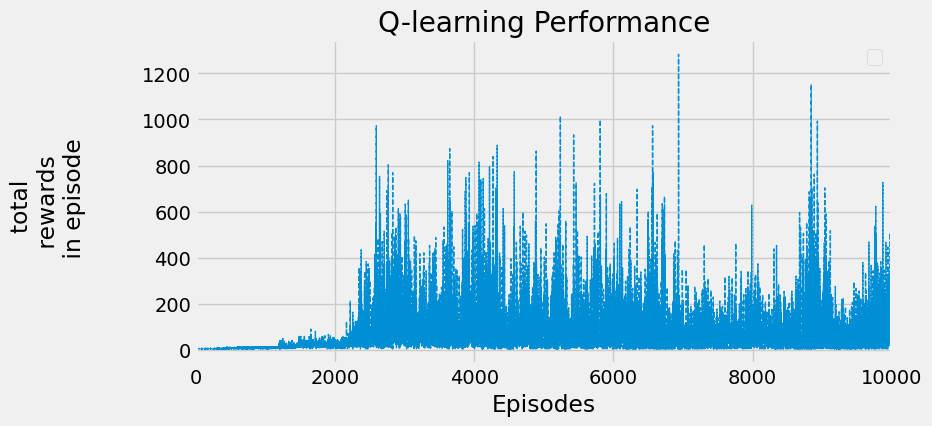

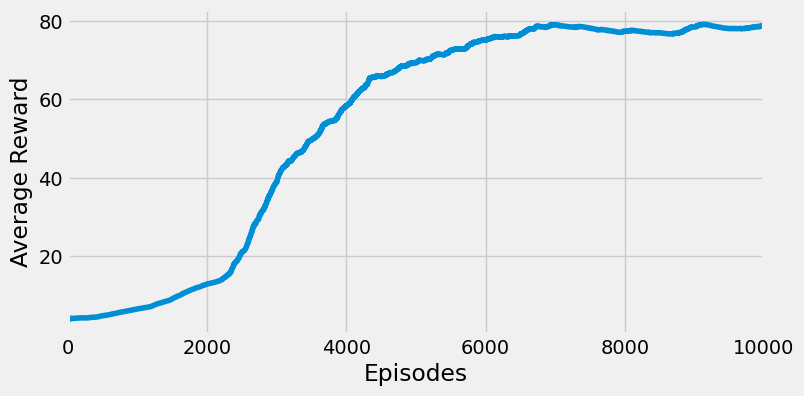

In [306]:
# Plot rewards per episode
def plot_total_rewards(rewards_per_episode,avg_rewards_all_episodes):
  plt.figure(figsize=(8, 4))
  plt.plot(range(len(rewards_per_episode)), rewards_per_episode , linestyle='dashed', linewidth=1)
  plt.title('Q-learning Performance')
  plt.xlabel("Episodes")
  plt.ylabel("total \n rewards \n in episode",labelpad=40)
  plt.xlim(0,10000)
  plt.legend()
  plt.show()

  plt.figure(figsize=(8, 4))
  plt.plot(avg_rewards_all_episodes)
  plt.xlabel('Episodes')
  plt.ylabel('Average Reward')
  plt.xlim(0,10000)
  plt.show()  

plot_total_rewards(rewards, avg_rewards)



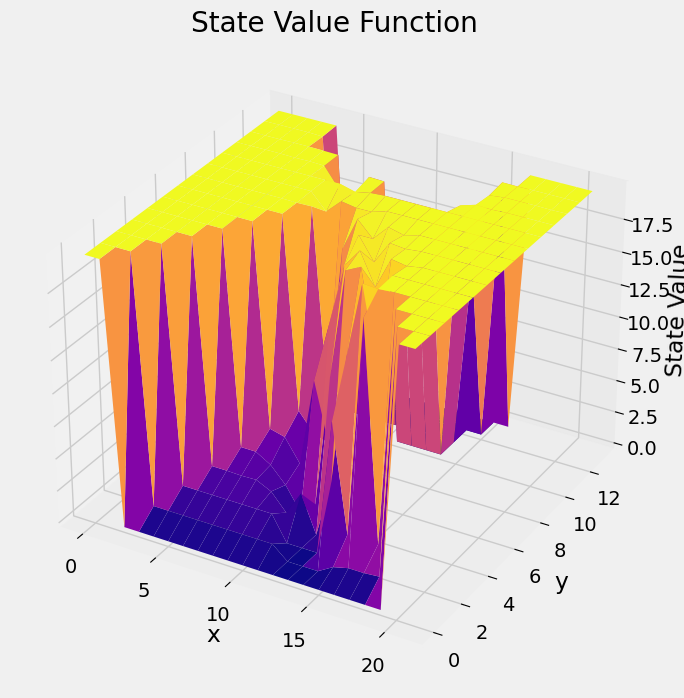

In [307]:
# plot the state-value function
def plot_v_table(env):
    x_range = np.arange(env.observation_space[1].n)
    y_range = np.arange(env.observation_space[0].n)
    X, Y = np.meshgrid(x_range, y_range)
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, env.v_table, cmap='plasma')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('State Value')
    ax.set_title('State Value Function')
    plt.show()

plot_v_table(agent)

# Expected SARSA

In [308]:
class ExpectedSarsaAgent():
    def __init__(self, observation_space, action_space, step_size=0.7, discount_factor=0.95, epsilon=0.05):
        self.observation_space = observation_space
        self.action_space = action_space
        self.step_size = step_size
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((observation_space[0].n, observation_space[1].n, action_space.n))
        self.v_table = np.zeros((observation_space[0].n, observation_space[1].n))
        self.converged = False

    def choose_action(self, state):
        if isinstance(state[0], int):  # if state is a tuple of coordinates
            state_indices = state
        else:  
            state_indices = (state[0][0], state[0][1])
        action_values = self.q_table[state_indices]
        if np.random.uniform(0, 1) < self.epsilon:
            # choose random action
            action = self.action_space.sample()
        else:
            # choose action with highest expected value
            action_probs = np.ones(self.action_space.n) * self.epsilon / self.action_space.n
            best_action = np.argmax(action_values)
            action_probs[best_action] += 1 - self.epsilon
            action = np.random.choice(np.arange(self.action_space.n), p=action_probs)
        return action

    def update_q_table(self, state, action, reward, next_state):
        if isinstance(state[0], int):  # if state is a tuple of coordinates
            state_indices = state
        else: 
            state_indices = (state[0][0], state[0][1])
        if isinstance(next_state[0], int):  # if next_state is a tuple of coordinates
            next_state_indices = next_state
        else:  
            next_state_indices = (next_state[0][0], next_state[0][1])
        action_values = self.q_table[next_state_indices]
        expected_action_value = np.dot(action_values, np.ones(self.action_space.n) * self.epsilon / self.action_space.n) + \
                            (1 - self.epsilon) * np.max(action_values)
        self.q_table[state_indices][action] += self.step_size * (reward + self.discount_factor * expected_action_value - self.q_table[state_indices][action])
        self.v_table[state_indices] = np.max(self.q_table[state_indices])
        

    def train(self, env, num_episodes, epsilon_decay=0.99,convergence_threshold=1e-3, convergence_window=100):
        rewards_per_episode = []
        avg_rewards_all_episodes = []
        q_diffs = []
        for i in range(num_episodes):
          state = env.reset()
          done = False
          total_reward = 0
          while not done:
              action = self.choose_action(state)
              next_state, reward, done, _,info = env.step(action)
              self.update_q_table(state, action, reward, next_state)
              state = next_state
              total_reward += reward
              # if done:
              #     break
          rewards_per_episode.append(total_reward)
          avg_rewards_all_episodes.append(np.mean(rewards_per_episode))
          
        # # Check for convergence
        #   if i >= convergence_window:
        #       q_diff = np.abs(self.q_table - self.old_q_table)
        #       q_diffs.append(np.mean(q_diff))
        #       if np.mean(q_diffs[-convergence_window:]) < convergence_threshold:
        #           if self.converged:
        #               print("Q-values have converged for at least {} consecutive episodes!".format(convergence_window))
        #               break
        #           else:
        #               self.converged = True
        #               print("Q-values have converged for the first time at episode {}!".format(i - convergence_window))
        #       else:
        #           self.converged = False
        #   self.old_q_table = np.copy(self.q_table)

        return rewards_per_episode,avg_rewards_all_episodes

      

In [309]:
# create the Q-learning agent
state = env.reset()
agent_1 = ExpectedSarsaAgent(env.observation_space, env.action_space)

# Train the agent
num_episodes = 10000
rewards_1, avg_rewards_1 = agent_1.train(env, num_episodes, epsilon_decay=0.99)

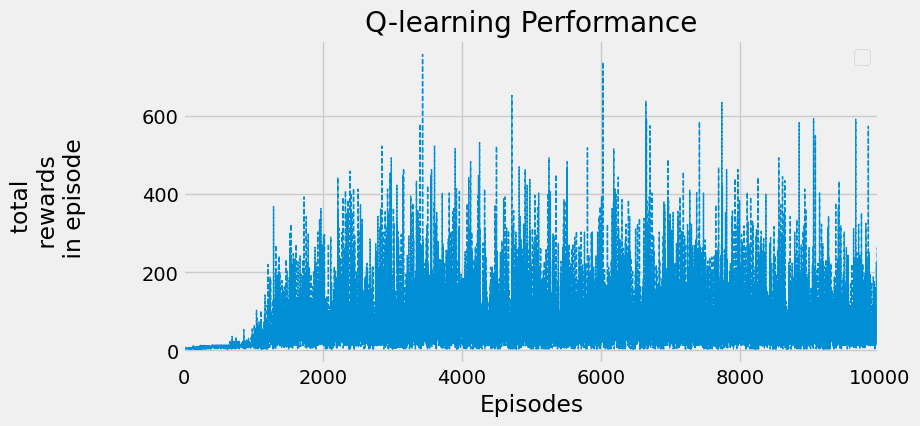

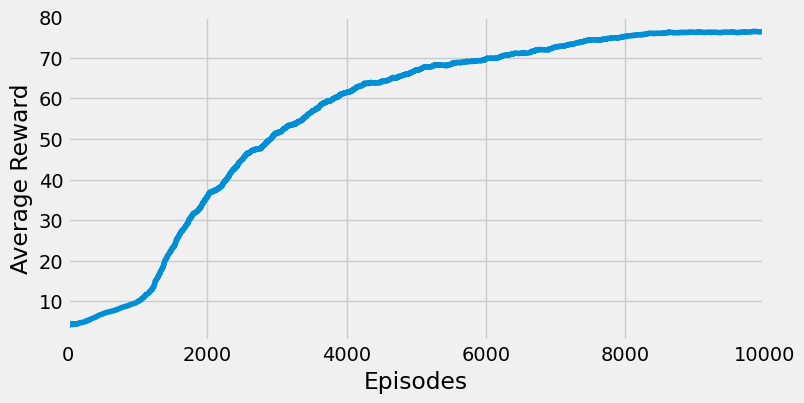

In [310]:
plot_total_rewards(rewards_1, avg_rewards_1)

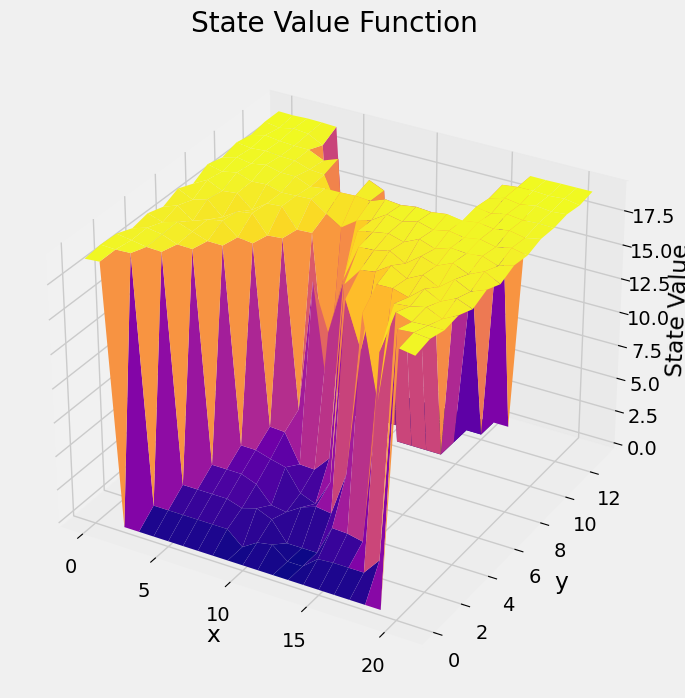

In [311]:
# plot the state-value function
plot_v_table(agent_1)

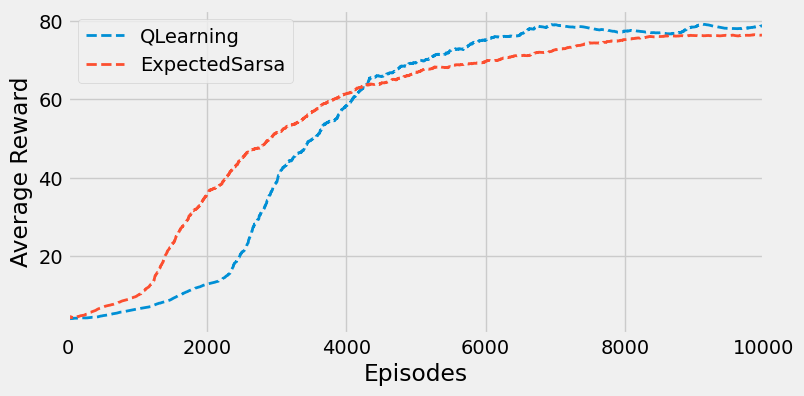

In [315]:
# combine the average reward per episode of two agents
plt.figure(figsize=(8, 4))
plt.plot(avg_rewards,linestyle='dashed', linewidth=2)
plt.plot(avg_rewards_1,linestyle='dashed', linewidth=2)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.xlim(0,10000)
plt.legend(['QLearning','ExpectedSarsa'])
plt.show()  

# Random Agent

In [278]:
#define random agent as a baseline
class RandomAgent():
    def __init__(self,observation_space,action_space):
        self.observation_space = observation_space
        self.action_space = action_space

    def train(self, env, num_episodes):
        rewards_per_episode = []
        avg_rewards_all_episodes = []

        for i in range(num_episodes):
            state = env.reset()
            total_reward = 0
            done = False
            while not done:
                action = env.action_space.sample()
                next_state, reward, done, _,info = env.step(action)
                total_reward += reward
                state = next_state
                
            rewards_per_episode.append(total_reward)
            avg_rewards_all_episodes.append(np.mean(rewards_per_episode))

        return rewards_per_episode,avg_rewards_all_episodes

In [279]:
# create the Q-learning agent
state = env.reset()
agent_2 = RandomAgent(env.observation_space, env.action_space)

# Train the agent
num_episodes = 10000
rewards_2, avg_rewards_2 = agent_2.train(env, num_episodes)

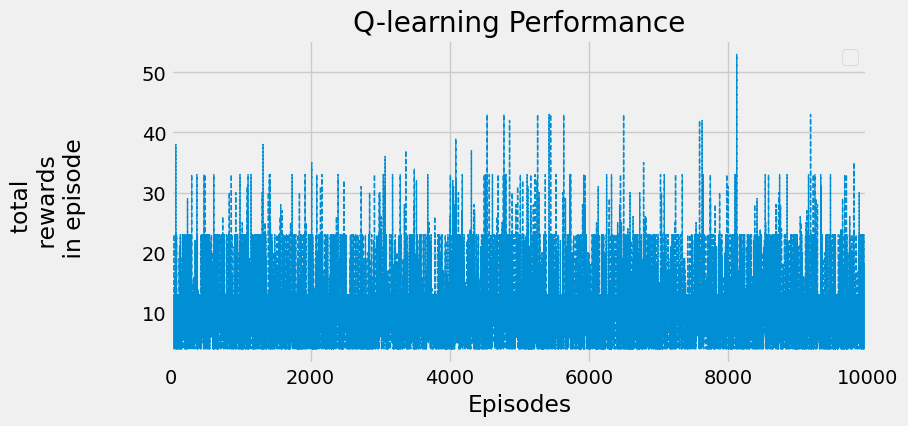

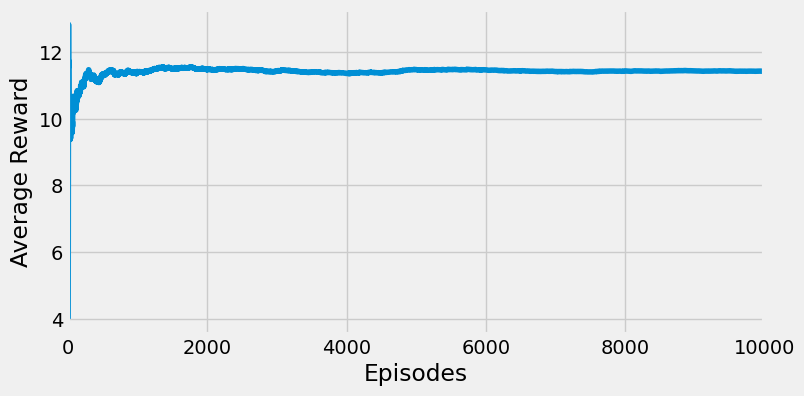

In [280]:
plot_total_rewards(rewards_2, avg_rewards_2)

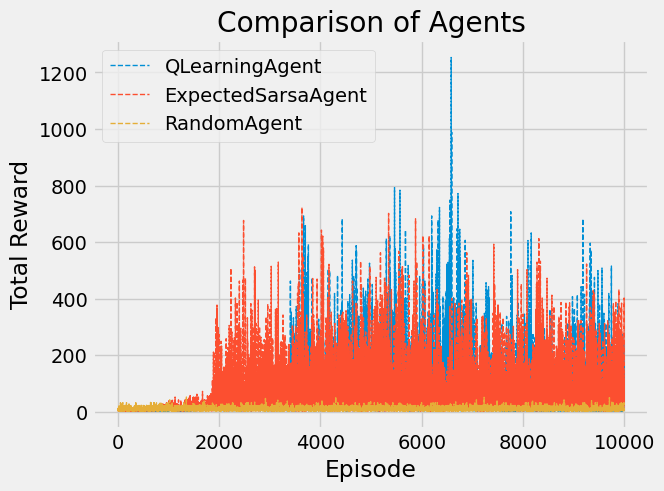

In [281]:
# create a list of agents to vividly show the comparisons in one graph

agents = [QLearningAgent(env.observation_space, env.action_space),\
          ExpectedSarsaAgent(env.observation_space, env.action_space), \
          RandomAgent(env.observation_space, env.action_space)]

# train each agent and store their rewards
rewards_per_agent = []
for agent in agents:
    rewards,_ = agent.train(env,num_episodes)
    rewards_per_agent.append(rewards)

# plot rewards for each agent in the same figure
fig, ax = plt.subplots()
for i in range(len(agents)):
    ax.plot(rewards_per_agent[i], label=type(agents[i]).__name__,linestyle='dashed', linewidth=1)
ax.set_xlabel('Episode')
ax.set_ylabel('Total Reward')
ax.set_title('Comparison of Agents')
ax.legend()
plt.show()

# Step-Size Tuning

In [316]:
step_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]  # list of step sizes to try
avg_rewards_q = []
avg_rewards_e = []

for step_size in step_sizes:
    agent_q = QLearningAgent(env.observation_space, env.action_space, step_size=step_size)
    rewards_per_episode_q, _ = agent_q.train(env, num_episodes)
    avg_rewards_q.append(np.mean(rewards_per_episode_q))

    agent_s = ExpectedSarsaAgent(env.observation_space, env.action_space, step_size=step_size)
    rewards_per_episode_e, _ = agent_s.train(env, num_episodes)
    avg_rewards_e.append(np.mean(rewards_per_episode_e))

KeyboardInterrupt: ignored

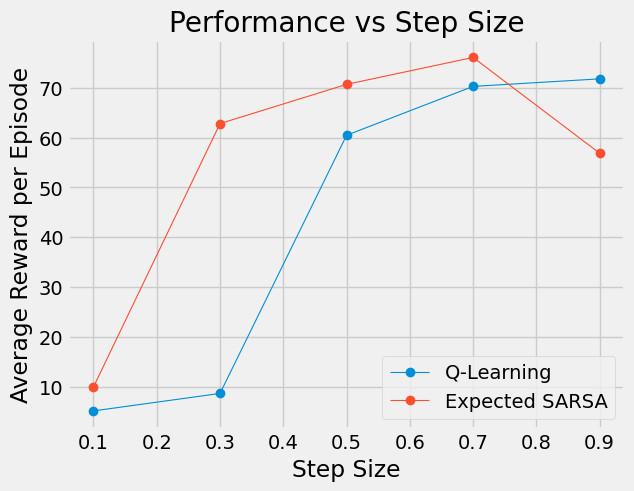

In [296]:
plt.plot(step_sizes, avg_rewards_q, linewidth=0.8, marker='o')
plt.plot(step_sizes, avg_rewards_e, linewidth=0.8, marker='o')
plt.xlabel('Step Size')
plt.ylabel('Average Reward per Episode')
plt.title('Performance vs Step Size')
plt.legend(['Q-Learning','Expected SARSA'])
plt.show()

